<a href="https://colab.research.google.com/github/luanakwon/ML_Pytorch_pre2022/blob/main/DCGAN_PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attempt to make GAN model from basic concept didn't go well, so I tried to recreate DCGAN from a tutorial in pytorchDocu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optimizer
import torch.nn.init as init
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.utils as vutils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##### HYPERPARAMETERS #####
epoch = 30
batch_size = 128  #논문에서 128로 해서 바꿈, 생성자,구별자도 맞게 변경해야할듯
# 학습에서 사용되는 이미지 크기
image_size=64
z_len = 100
learning_rate = 0.0002
num_workers = 4
#인풋 이미지 채널 수
nc=3
#생성자 구별자 거치는 맵의 크기
ngf=64
ndf=64

In [ ]:
# imagenet_data = dsets.ImageFolder('drive/MyDrive/celebA/',transform=transforms.ToTensor())
# data_loader = DataLoader(imagenet_data,
#                         batch_size=batch_size,
#                         shuffle=True,
#                         num_workers=1,drop_last=True)

dataset=dsets.ImageFolder(root='drive/MyDrive/celebA/',
                         transform=transforms.Compose([
                          transforms.CenterCrop(150),                
                          transforms.Resize((image_size,image_size)),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))                           
                         ]))
dataloader=DataLoader(dataset,batch_size=batch_size, 
                      shuffle=True,num_workers=num_workers, drop_last=True)


In [ ]:
# #data 로딩이 잘 되었나 확인
# #data_loader는 (이미지텐서,레이블) 튜플이고, 이미지텐서는 배치, 채널, 새로, 가로 인듯
# #채널이 rgb가 아님..왜?

# print(len(dataloader))
# for i,j in dataloader:
#   print(i.shape)
#   plt.imshow(np.transpose(i[0].numpy(),(1,2,0)))
#   break

# plt.show()

In [ ]:
# 내코드
def init_weight(m):
  if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d:
    init.normal_(m.weight.data,std=0.02)

# 튜토 코드
# def init_weight(m):
#   classname = m.__class__.__name__
#   if classname.find('Conv') != -1:
#     nn.init.normal_(m.weight.data, 0.0,0.02)
#   elif classname.find('BatchNorm') != -1:
#     nn.init.normal_(m.weight.data, 1.0, 0.02)
#     nn.init.constant_(m.bias.data, 0)

In [ ]:
# DCGAN 그림을 보니까 생성자에서 커널 5 스트 2 로 하는데 그럼 그림에서 말한 사이즈가 안나옴
# 알고보니까 커널이 5가 아니라 2임 ( 아웃이 5라는거인듯)
#generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # self.layer_lin = nn.Sequential(
    #     nn.Linear(z_len,4*4*1024),
    #     nn.BatchNorm1d(4*4*1024),  # Batch Normalization 추가
    #     # nn.ReLU() 프로젝션 레이어엔 액티베이션이 필요없음(matmul)
    # )
    self.layer_conv = nn.Sequential(
        # z_len,1,1
        nn.ConvTranspose2d(z_len, ngf*8,4,1,bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True),
        # ngf*8,4,4
        nn.ConvTranspose2d(in_channels=ngf*8,out_channels=ngf*4,
                           kernel_size=4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        # ngf*4,8,8
        nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),
        # ngf*2,16,16
        nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # ngf*32*32
        nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
        nn.Tanh() 
        # nc,64,64

        #Tanh as the last layer of the generator output
        # Sigmoid와 비교하여 tanh는 출력 범위가 더 넓고 경사면이 큰 범위가 더 크기 때문에 더 빠르게 수렴하여 학습하는 특성
        # 수정 : 논문에서는 maxout과 같은 것과 비교해서 정해진 범위의 아웃풋이 나오는 tanh가 좋다고 함
        # 단 논문에서는 처음 이미지를 [-1,1] 범위로 프로세싱한 뒤 사용하였기 때문에, [0,1]인 이미지를 사용할 땐 sigmoid를 쓰는게 동일한 것이라 생각됨
        
    )
  
  def forward(self,x):
    out = x.view(batch_size, z_len, 1,1)
    out = self.layer_conv(out)
    return out

In [ ]:
#discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layer_conv = nn.Sequential(
        #nc * 64 * 64
        #kernel 2 stride 2 padding 0
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,True),

        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,True),

        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,True),

        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2,True),
        # batch, 512, 4, 4
        # kernel 4 stride 1
        nn.Conv2d(ndf*8,1,4,1,bias=False),
        nn.Sigmoid()
    )

  def forward(self,x):
    out = self.layer_conv(x)
    out = out.view(batch_size,-1)
    return out

In [ ]:
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device 수정
device = torch.device('cuda') if (torch.cuda.is_available())else torch.device('cpu')
print(device)

generator = nn.DataParallel(Generator()).to(device)
discriminator = nn.DataParallel(Discriminator()).to(device)

generator.apply(init_weight)
discriminator.apply(init_weight)

print(generator,discriminator)

cuda
DataParallel(
  (module): Generator(
    (layer_conv): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), s

No pre-processing was applied to training images besides scaling to the range of the tanh activation
function [-1, 1]. All models were trained with mini-batch stochastic gradient descent (SGD) with
a mini-batch size of 128. All weights were initialized from a zero-centered Normal distribution
with standard deviation 0.02. In the LeakyReLU, the slope of the leak was set to 0.2 in all models.
While previous GAN work has used momentum to accelerate training, we used the Adam optimizer
(Kingma & Ba, 2014) with tuned hyperparameters.

--> So SGD for generator and ADAM for discriminator?
But isnt it generator that need to accelerate training since gen is way slower than dis?

In [ ]:
loss_func = nn.BCELoss()
gen_optim = optimizer.Adam(generator.parameters(),lr=learning_rate, betas=(0.5,0.999))
#gen_optim = optimizer.SGD(generator.parameters(),lr=learning_rate*2)
dis_optim = optimizer.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.5,0.999))

ones_label = torch.ones(batch_size,1).to(device)
zeros_label = torch.zeros(batch_size,1).to(device)

In [ ]:
# G_loss = []
# D_loss = []

# for i in range(epoch):
#   for j, (image,label) in enumerate(dataloader):
#     #discriminator learning
    
#     dis_optim.zero_grad()

#     z = init.normal_(torch.Tensor(batch_size,z_len),std=1).to(device)
#     gen_fake = generator.forward(z)
#     dis_fake = discriminator.forward(gen_fake)

#     image = image.to(device)
#     dis_real = discriminator.forward(image)
#     dis_loss = torch.mean(loss_func(dis_fake, zeros_label)) + torch.mean(loss_func(dis_real, ones_label))
#     #dis_loss = torch.mean(dis_fake) + torch.mean(1- dis_real)
#     dis_loss.backward()
#     dis_optim.step()
      
#     for k in range(1):
#       #generator learning
#       gen_optim.zero_grad()

#       z = init.normal_(torch.Tensor(batch_size,z_len),std=1).to(device)
#       gen_fake = generator.forward(z)
#       dis_fake = discriminator.forward(gen_fake)

#       gen_loss = torch.mean(loss_func(dis_fake,ones_label))
#       #gen_loss = torch.mean(1 - dis_fake)
#       gen_loss.backward()
#       gen_optim.step()


#     G_loss.append(gen_loss.item())
#     D_loss.append(dis_loss.item())
    
#     if j%50 == 0:
#       print("%d dis_loss: %.4f, gen_loss: %.4f D(image): %.4f D(fake): %.4f" 
#             %(i,dis_loss.item(),gen_loss.item(),torch.mean(dis_real).item(),torch.mean(dis_fake).item()))


구별자 학습 시 실제 이미지와 생성자의 이미지로 한번씩 loss와 backpropagation을 진행하고, 생성자 학습(같은 z 사용)

epoch을 70에서 5로 줄여 봄

한 배치마다 loss를 측정해서 그래프로 표현

In [ ]:
G_loss = []
D_loss = []

for i in range(epoch):
  for j, (image,label) in enumerate(dataloader):
    #discriminator loss for real data

    dis_optim.zero_grad()

    dis_real = discriminator.forward(image)
    real_loss = loss_func(dis_real,ones_label)

    real_loss.backward()

    z = init.normal_(torch.Tensor(batch_size,z_len)).to(device)
    gen_fake = generator.forward(z)
    dis_fake = discriminator.forward(gen_fake)
    fake_loss = loss_func(dis_fake,zeros_label)

    fake_loss.backward()

    dis_loss = real_loss + fake_loss
    dis_optim.step()

    #generator loss

    for ii in range(random.randint(0,2)):
      gen_optim.zero_grad()

      gen_fake = generator.forward(z)
      dis_fake = discriminator.forward(gen_fake)
      gen_loss = loss_func(dis_fake,ones_label)

      gen_loss.backward()
      gen_optim.step()

    G_loss.append(gen_loss.item())
    D_loss.append(dis_loss.item())
    
    if j%50 == 0:
      print("%d dis_loss: %.4f, gen_loss: %.4f D(image): %.4f D(fake): %.4f" 
            %(i,dis_loss.item(),gen_loss.item(),torch.mean(dis_real).item(),torch.mean(dis_fake).item()))


0 dis_loss: 1.5573, gen_loss: 0.0924 D(image): 0.4368 D(fake): 0.9166
0 dis_loss: 1.1473, gen_loss: 8.5572 D(image): 0.8971 D(fake): 0.0005
0 dis_loss: 1.3129, gen_loss: 4.0963 D(image): 0.9176 D(fake): 0.0306
0 dis_loss: 1.2980, gen_loss: 5.5626 D(image): 0.3979 D(fake): 0.0833
0 dis_loss: 1.0627, gen_loss: 3.7291 D(image): 0.4868 D(fake): 0.1273
0 dis_loss: 1.0929, gen_loss: 4.9946 D(image): 0.7619 D(fake): 0.0181
0 dis_loss: 0.1969, gen_loss: 4.0988 D(image): 0.8671 D(fake): 0.0264
0 dis_loss: 0.6248, gen_loss: 1.5723 D(image): 0.6414 D(fake): 0.0216
0 dis_loss: 0.6919, gen_loss: 4.4980 D(image): 0.9469 D(fake): 0.0182
1 dis_loss: 0.4191, gen_loss: 4.0956 D(image): 0.7403 D(fake): 0.0538
1 dis_loss: 0.3035, gen_loss: 2.0938 D(image): 0.9207 D(fake): 0.1559
1 dis_loss: 0.2938, gen_loss: 3.4684 D(image): 0.8170 D(fake): 0.0320
1 dis_loss: 0.6322, gen_loss: 3.8454 D(image): 0.8125 D(fake): 0.0319
1 dis_loss: 0.2094, gen_loss: 1.5664 D(image): 0.8889 D(fake): 0.2793
1 dis_loss: 1.8108, 

In [ ]:
save_path = './drive/MyDrive/omok/'
torch.save(generator.state_dict(),save_path + 'DCGAN_generatorC2.pth')
torch.save(discriminator.state_dict(),save_path + 'DCGAN_discriminatorC2.pth')

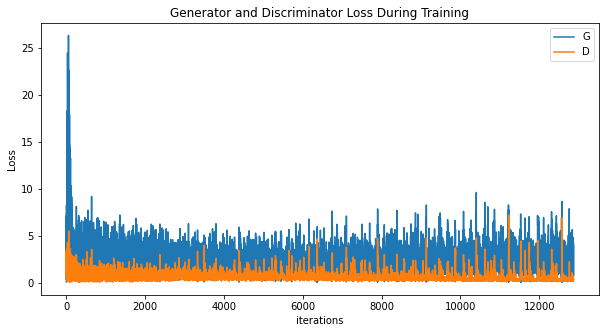

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# 구별자 편차 F
# 한배치에 생성자 rand(0,2)학습
# 에폭 30

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 64, 64])

35 [0.00296737] 10 [0.67510843]


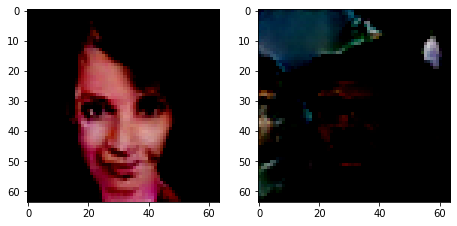

In [ ]:
import numpy as np


with torch.no_grad():
  z = init.normal_(torch.Tensor(batch_size, z_len),std=1).to(device)
  gen_fake = generator.forward(z)
  dis_fake = discriminator.forward(gen_fake).cpu().detach().numpy()
  print(gen_fake.shape)
  gen_fake = np.transpose(gen_fake.cpu().detach().numpy(), (0,2,3,1))
  print()
  maxi = np.argmax(dis_fake)
  mini = np.argmin(dis_fake)
  
  imagelist = []
  imagelist.append(gen_fake[mini])
  imagelist.append(gen_fake[maxi])

  print(mini, dis_fake[mini], maxi, dis_fake[maxi])
  plt.figure(figsize=(20,30))
  for i in range(len(imagelist)):
      plt.subplot(1,5,i+1)
      plt.imshow(imagelist[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


118 [0.44790903] 100 [0.99875736]


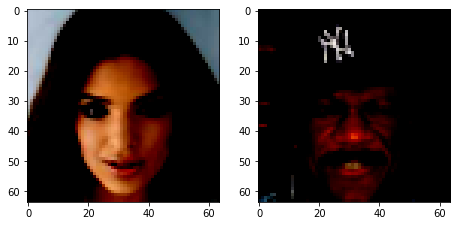

In [ ]:
for (image,label) in dataloader:
  with torch.no_grad():
    dis_real = discriminator.forward(image).cpu().detach().numpy()

    maxi = np.argmax(dis_real)
    mini = np.argmin(dis_real)

    image = np.transpose(image.cpu().detach().numpy(), (0,2,3,1))
    imagelist = []
    imagelist.append(image[mini])
    imagelist.append(image[maxi])

    print(mini, dis_real[mini], maxi, dis_real[maxi])
    plt.figure(figsize=(20,30))
    for i in range(len(imagelist)):
        plt.subplot(1,5,i+1)
        plt.imshow(imagelist[i])
  break

In [ ]:
show_saved_result = True
G_path = './drive/MyDrive/omok/DCGAN_generatorC2.pth'
if show_saved_result:
  generator.load_state_dict(torch.load(G_path))


In [ ]:
z = init.normal_(torch.Tensor(batch_size,z_len))
npzin = z.numpy()

In [ ]:
a = np.array([1,2,3])
a = torch.Tensor([a]*3)
print(a)

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])


tensor([[-0.6623,  0.3116, -0.1822,  ..., -0.7866, -0.2410, -0.6833],
        [-0.6623,  0.3116, -0.1822,  ..., -0.7866, -0.2410, -0.6833],
        [-0.6623,  0.3116, -0.1822,  ..., -0.7866, -0.2410, -0.6833],
        ...,
        [-0.6623,  0.3116, -0.1822,  ..., -0.7866, -0.2410, -0.6833],
        [-0.6623,  0.3116, -0.1822,  ..., -0.7866, -0.2410, -0.6833],
        [-0.6623,  0.3116, -0.1822,  ..., -0.7866, -0.2410, -0.6833]])
result


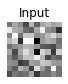

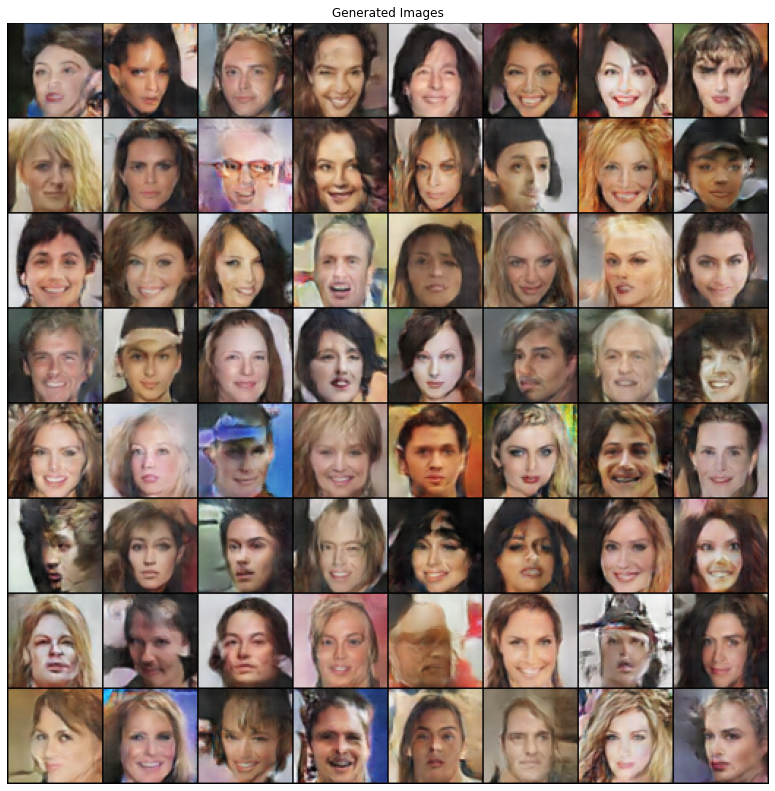

In [ ]:
with torch.no_grad():
  z_in = torch.Tensor([npzin[5]]*batch_size)
  print(z_in)
  gen_fake = generator.forward(z)

  plt.figure(figsize=(1,1))
  plt.axis("off")
  plt.title("Input")
  plt.imshow(z_in.view(batch_size,10,10)[0],cmap='gray')

  # plt.figure(figsize=(10,10))
  # plt.axis("off")
  # plt.title("Input Feature Maps")
  # plt.imshow(np.transpose(vutils.make_grid(z_in.view(batch_size,1,10,10)[:64],padding=1,normalize=True),(1,2,0)),cmap='gray')

  plt.figure(figsize=(14,14))
  plt.axis("off")
  plt.title("Generated Images")
  plt.imshow(np.transpose(vutils.make_grid(gen_fake[:64], padding=1, normalize=True).cpu(),(1,2,0)))

  print('result')